In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, train_test_split, RandomizedSearchCV, validation_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import plot_roc_curve

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import make_column_selector
from sklearn.linear_model import Ridge, Lasso, ElasticNet

from sklearn.cluster import FeatureAgglomeration

from category_encoders import TargetEncoder, WOEEncoder


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def _get_model_name(model):
    """
        Returns a string with the name of a sklearn model
            model: Sklearn stimator class
    """
    if isinstance(model, Pipeline):
        estimator = model.steps[-1][1]
        name = "Pipeline_" + str(estimator)[:str(estimator).find("(")]
    else: 
        name = str(model)[:str(model).find("(")]
    return name 

def plot_cv_score(X, y, models_list, cv = 5, scoring = None, refit = True):
    """ 
        X: numpy_array/pandas dataframe n_rows, m_features
        y: numpy_array/pandas dataframe n_rows
        Plots min, max and avg kfold crosval_score for a list of models
    
    """

    
    
    names, scores, min_score, max_score, mean_score = list(), list(), list(), list(), list()

    for model in models_list:
        name = _get_model_name(model)
        names.append(name)

        if refit:
            model.fit(X, y)
        
        score = cross_val_score(model, X, y, cv = cv, scoring = scoring, n_jobs= -1)

        min_score.append(np.min(score))
        max_score.append(np.max(score))
        mean_score.append(np.mean(score))
        scores.append(score)
    
    frame_summary = pd.DataFrame({'Min':min_score, 'Average': mean_score, 'Max': max_score,}, index = names).sort_values(by = 'Average')

    frame_scores = pd.DataFrame(np.vstack(scores).T, columns = names) 


    fig, ax  = plt.subplots(1,2, figsize = (15,7))

    frame_summary.plot.barh(edgecolor = 'black', ax = ax[0], cmap = 'RdYlBu')
    ax[0].legend(loc = 'best')
    ax[0].set_xlabel("Score")

    frame_scores.boxplot(ax = ax[1])
    ax[1].set_title("Model scores distribution")
    ax[1].set_ylabel("Score")
    ax[1].tick_params(labelrotation=90)

In [0]:
def optimize_parameters(model, param_dict, X, y, cv = None, metric = None, random_state = 1990):
    """
    Performs a cross validation strategy to find the best set of parameters from param_dict
    """

    grid = RandomizedSearchCV(estimator= model,
                              param_distributions= param_dict,
                              scoring = metric,
                              cv = cv,
                              random_state= random_state,
                              n_jobs= -1,
                              return_train_score= True).fit(X, y)
    
    return grid

In [0]:
def plot_validation_curve(model, X, y, param_name, param_range, metric = None, cv = None):

    train_scores, test_scores = validation_curve(
        model, X, y, param_name= param_name, param_range = param_range,
        scoring= metric, cv = cv, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                color="red", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2,
                    color="red", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.2,
                    color="navy", lw=lw)
    plt.legend(loc="best")

## Task 2 Regression on Sydney Dataset (60 points)
### You can load the Sydney housing dataset from ​ https://www.kaggle.com/shree1992/housedata where you can also find a description. The goal is to predict the ‘price’ column. For this assignment you can ignore the date. Please don’t make any kernels public on Kaggle before the assignment ends.
### 2.1 Determine which features are continuous vs categorical. Drop rows without a valid sales price.
### 2.2 Visualize the univariate distribution of each continuous feature, and the distribution of the target. Do you notice anything? Is there something that might require special treatment?
### 2.3 Visualize the dependency of the target on each continuous feature (2d scatter plot).
### 2.4 Split data in training and test set. Do not use the test-set unless for a final evaluation in 2.5.
### Use ColumnTransformer and pipeline to encode categorical variables (your choice of OneHotEncoder or another one from the categorical_encoder package, or both). Impute missing values using SimpleImputer. Evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNet using cross-validation with the default parameters. Does scaling the data (within the pipeline) with StandardScaler help? Use the preprocessing that works best going forward.
### 2.5 Tune the parameters of the models using GridSearchCV. Do the results improve? Visualize the dependence of the validation score on the parameters for Ridge, Lasso and ElasticNet.
### 2.6 Visualize the 20 most important coefficients of the resulting models. Do they agree on which features are important?

In [0]:
data = pd.read_csv("datasets_46927_85203_data.csv")

In [6]:
data.sample(7)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4044,2014-07-07 00:00:00,509900.0,3.0,2.50,3030,9053,2.0,0,0,3,3030,0,2009,0,5221 NE 7th Pl,Renton,WA 98059,USA
3872,2014-07-02 00:00:00,262000.0,5.0,1.00,1870,7800,1.0,0,0,3,1580,290,1962,2003,903 S 101st St,Seattle,WA 98168,USA
3431,2014-06-26 00:00:00,225500.0,2.0,1.75,1590,11276,1.0,0,0,4,1590,0,1972,0,936 Pike Pl NE,Auburn,WA 98002,USA
930,2014-05-19 00:00:00,818000.0,2.0,2.50,2380,9374,1.0,0,2,3,2380,0,2011,0,12449 240th Pl NE,Redmond,WA 98053,USA
1564,2014-05-29 00:00:00,635200.0,4.0,1.75,1640,4240,1.0,0,0,5,920,720,1921,0,6517 Dibble Ave NW,Seattle,WA 98117,USA
2677,2014-06-17 00:00:00,382500.0,4.0,2.50,2210,7079,2.0,0,0,3,2210,0,1993,0,11824 SE 203rd St,Kent,WA 98031,USA
1467,2014-05-28 00:00:00,968000.0,6.0,2.75,3610,17580,1.0,0,4,5,2070,1540,1959,0,20303 SE 40th St,Sammamish,WA 98075,USA


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [0]:
data.yr_built = data.yr_built.astype("object")
data.yr_renovated = data.yr_renovated.astype("object")



In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,4600.0,551962.988473,563834.702547,0.0,322875.00,460943.461539,654962.50,26590000.0
bedrooms,4600.0,3.400870,0.908848,0.0,3.00,3.000000,4.00,9.0
bathrooms,4600.0,2.160815,0.783781,0.0,1.75,2.250000,2.50,8.0
sqft_living,4600.0,2139.346957,963.206916,370.0,1460.00,1980.000000,2620.00,13540.0
sqft_lot,4600.0,14852.516087,35884.436145,638.0,5000.75,7683.000000,11001.25,1074218.0
floors,4600.0,1.512065,0.538288,1.0,1.00,1.500000,2.00,3.5
waterfront,4600.0,0.007174,0.084404,0.0,0.00,0.000000,0.00,1.0
view,4600.0,0.240652,0.778405,0.0,0.00,0.000000,0.00,4.0
condition,4600.0,3.451739,0.677230,1.0,3.00,3.000000,4.00,5.0
sqft_above,4600.0,1827.265435,862.168977,370.0,1190.00,1590.000000,2300.00,9410.0


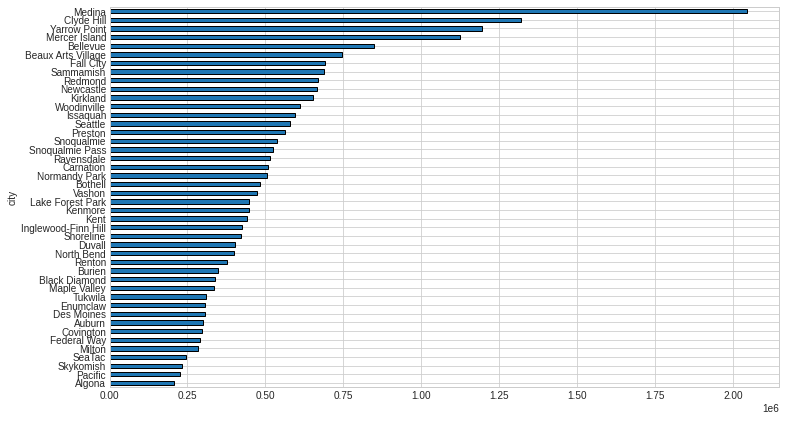

In [10]:
data.groupby("city").price.mean().sort_values().plot.barh(figsize = (12,7), edgecolor = "black");

2.1 Determine which features are continuous vs categorical. Drop rows without a valid sales price.

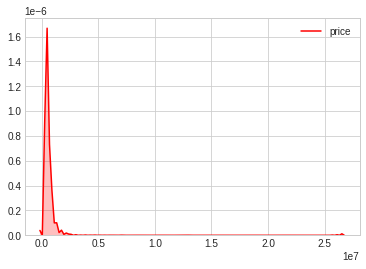

In [11]:
sns.kdeplot(data.price, cumulative = False, color = "red", shade = True);

In [0]:
# Remove those with price 0
data = data[data.price > 0].copy()

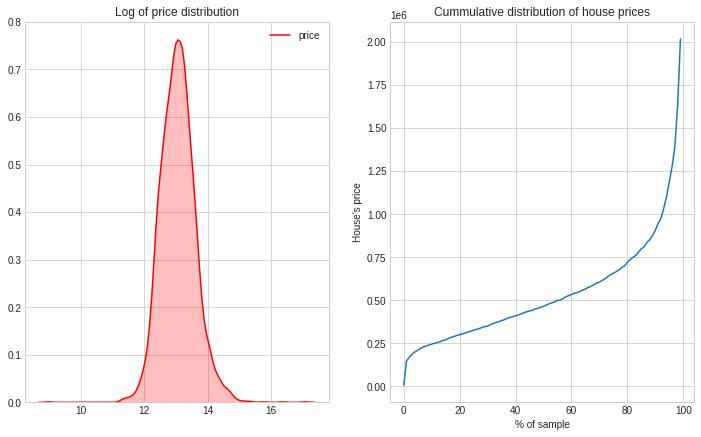

In [13]:
percentiles = [np.percentile(data.price, x) for x in range(0,100)]

fig, ax = plt.subplots(1,2, figsize = (12,7))
sns.kdeplot(np.log(data.price), cumulative = False, color = "red", shade = True, ax = ax[0])
ax[0].set_title("Log of price distribution")

ax[1].plot(percentiles)
ax[1].set_title("Cummulative distribution of house prices")
ax[1].set_xlabel("% of sample")
ax[1].set_ylabel("House's price");

2.2 Visualize the univariate distribution of each continuous feature, and the distribution of the target. Do you notice anything? Is there something that might require special treatment?

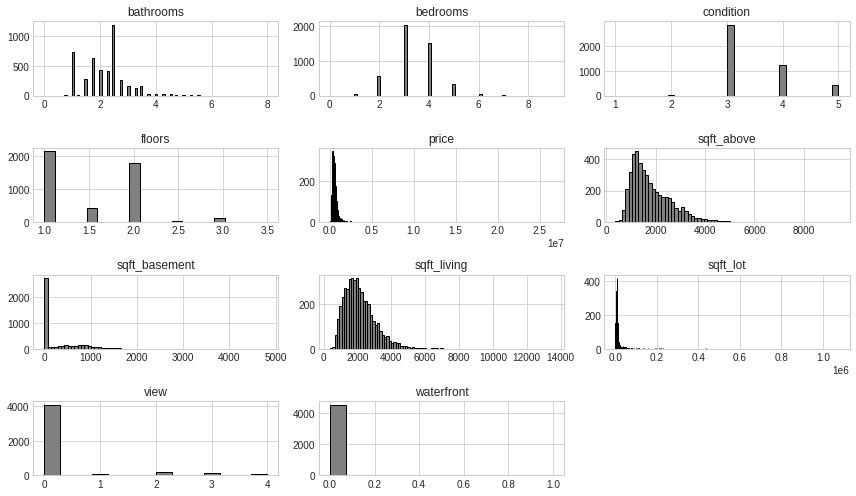

In [14]:
# target feature (Price) is highly skwed to the left so it might be difficult for some models to learn the target function (Linear Regression)
data.hist(bins = "auto", edgecolor = "black", color = "grey", figsize = (12,7))
plt.tight_layout();

2.3 Visualize the dependency of the target on each continuous feature (2d scatter plot).

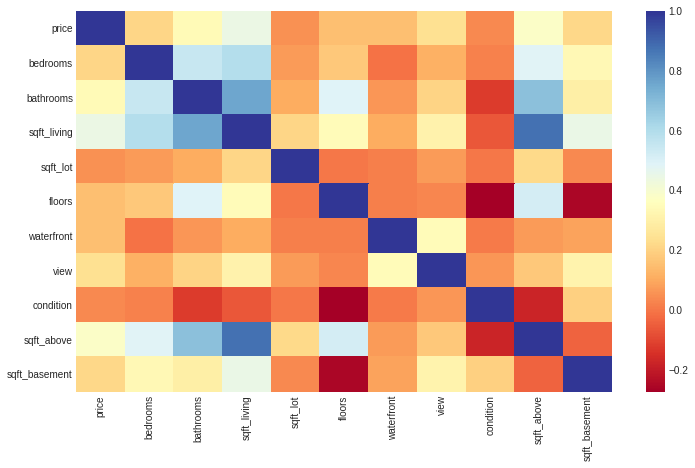

In [15]:
fig, ax = plt.subplots(figsize = (12,7))
sns.heatmap(data.select_dtypes(exclude= "object").corr(), cmap = "RdYlBu", ax = ax);

2.4 Split data in training and test set. Do not use the test-set unless for a final evaluation in 2.5.
Use ColumnTransformer and pipeline to encode categorical variables (your choice of OneHotEncoder or another one from the categorical_encoder package, or both). Impute missing values using SimpleImputer. Evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNet using cross-validation with the default parameters. Does scaling the data (within the pipeline) with StandardScaler help? Use the preprocessing that works best going forward.

In [16]:
# Since the data has no missing values I'm going to add some missing randomly (5%)
for col in data.columns:
    data.loc[data.sample(frac=0.01, random_state = 1990).index, col] = pd.np.nan

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
data.isnull().sum()

date             46
price            46
bedrooms         46
bathrooms        46
sqft_living      46
sqft_lot         46
floors           46
waterfront       46
view             46
condition        46
sqft_above       46
sqft_basement    46
yr_built         46
yr_renovated     46
street           46
city             46
statezip         46
country          46
dtype: int64

In [18]:
data.sample(7)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
1124,2014-05-21 00:00:00,700000.0,4.0,3.25,2780.0,7875.0,2.0,0.0,0.0,3.0,2780.0,0.0,2006,0,543 N 138th St,Seattle,WA 98133,USA
4430,2014-05-29 00:00:00,408900.0,3.0,1.75,2930.0,19876.0,1.0,0.0,0.0,3.0,2030.0,900.0,1993,0,12542 NE 160th Pl,Woodinville,WA 98072,USA
3939,2014-07-03 00:00:00,1042031.0,4.0,5.00,4110.0,43560.0,2.0,0.0,0.0,4.0,4110.0,0.0,1978,2000,2808 120th Ave NE,Bellevue,WA 98005,USA
563,2014-05-13 00:00:00,415000.0,3.0,1.75,1960.0,5000.0,1.0,0.0,0.0,5.0,980.0,980.0,1911,1984,4958 12th Ave S,Seattle,WA 98108,USA
1251,2014-05-23 00:00:00,595000.0,2.0,1.50,1030.0,4500.0,1.0,0.0,0.0,3.0,830.0,200.0,1924,2011,2726 Mayfair Ave N,Seattle,WA 98109,USA
911,2014-05-19 00:00:00,319950.0,4.0,1.75,2310.0,8045.0,1.0,0.0,0.0,4.0,1650.0,660.0,1976,1992,16336 131st Ave SE,Renton,WA 98058,USA
1639,2014-05-30 00:00:00,800000.0,2.0,2.25,1730.0,31491.0,2.0,1.0,2.0,4.0,1730.0,0.0,1947,1988,10060 SW Dock St,Vashon,WA 98070,USA


In [0]:
X_train, X_val, y_train, y_val = train_test_split(data.drop(["price", "date", "country", "street", "statezip"], axis = 1), data.price, test_size = .4, random_state = 1990)

In [0]:
preprocesor = make_column_transformer((StandardScaler(), make_column_selector(dtype_exclude= "object")),
                                      (TargetEncoder(), make_column_selector(dtype_include= "object")))

In [0]:
lasso = Pipeline([("preprocesor",preprocesor), ("model", Lasso())])
ridge = Pipeline([("preprocesor",preprocesor), ("model", Ridge())])
en = Pipeline([("preprocesor",preprocesor), ("model", ElasticNet())])

models = [lasso, ridge, en]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27002013725044.344, tolerance: 52915383451.64536
  positive)


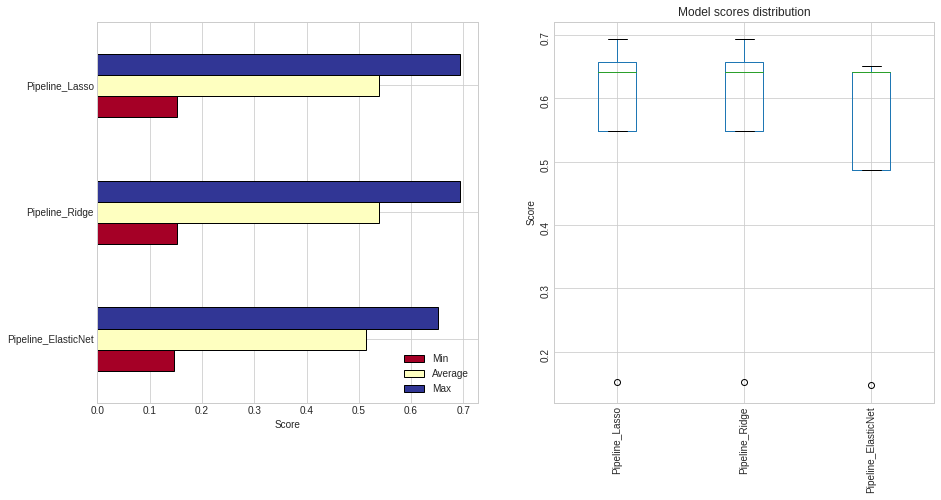

In [94]:
plot_cv_score(X_train, y_train,models)

2.5 Tune the parameters of the models using GridSearchCV. Do the results improve? Visualize the dependence of the validation score on the parameters for Ridge, Lasso and ElasticNet.

In [100]:
param_dict = {"model__alpha":np.logspace(-2.5,2.5,10)}

opt_lasso = optimize_parameters(lasso, param_dict,X_train, y_train, cv = 7)
opt_ridge = optimize_parameters(ridge, param_dict,X_train, y_train, cv = 7)
opt_en = optimize_parameters(en, param_dict,X_train, y_train, cv = 7)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132873254166432.58, tolerance: 52915383451.64536
  positive)


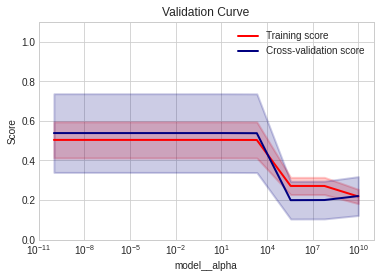

In [112]:
plot_validation_curve(lasso,X_train, y_train, "model__alpha", np.logspace(-10,10,10))

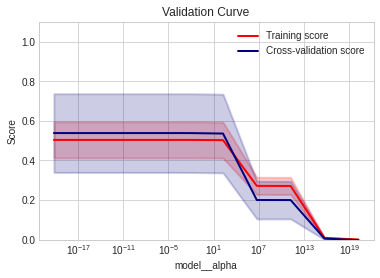

In [113]:
plot_validation_curve(ridge,X_train, y_train, "model__alpha", np.logspace(-20.2,20.2,10))

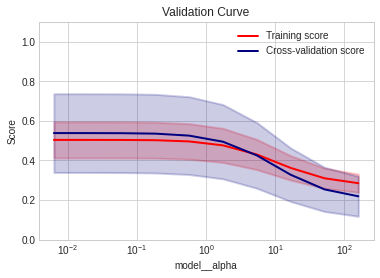

In [114]:
plot_validation_curve(en,X_train, y_train, "model__alpha", np.logspace(-2.20,2.20,10))